# 간단한 회로 만들기

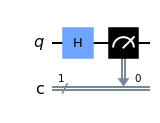

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qr = QuantumRegister(1,name='q')
cr = ClassicalRegister(1,name='c')
qc = QuantumCircuit(qr,cr)

########## your code goes here #######

qc.h(qr[0])
qc.measure(qr[0], cr[0])


qc.draw("mpl")

# 이것도 sample example

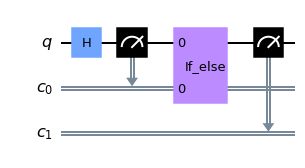

In [16]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1,name='q')
cr = ClassicalRegister(2,name='c')
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
c0, c1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, c0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((c0, 1)):
    # if the condition is satisfied (c0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, c1)
qc.draw(output="mpl", idle_wires=False)

In [17]:
from qiskit import Aer

# initialize the simulator
backend_sim = Aer.get_backend("aer_simulator")

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'01': 502, '00': 522}


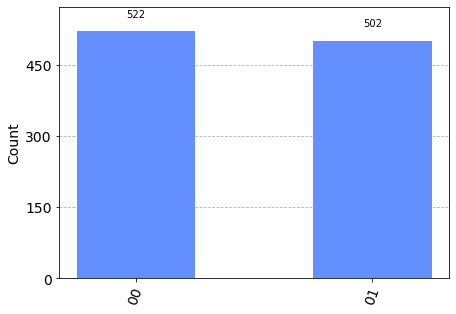

In [18]:
from qiskit.visualization import *

# plot histogram
plot_histogram(reset_sim_counts)

# Exercise 1

# 업그레이드 된 연습문제

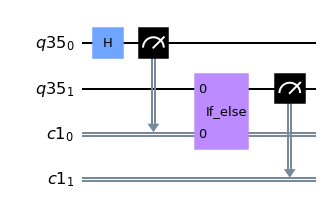

In [20]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

q0, q1 = qr
b0, b1 = cr

qc = QuantumCircuit(qr, cr)
qc.h(q0)
qc.measure(q0, b0)

with qc.if_test((b0, 0)) as else_:
    qc.x(q1)
with else_:
    qc.h(q1)


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

In [21]:
backend_sim = Aer.get_backend("aer_simulator")

job_1 = backend_sim.run(qc)
result_1 = job_1.result()
counts_1 = result_1.get_counts()

print(f"Counts: {counts_1}")

Counts: {'10': 491, '01': 273, '11': 260}


# Exercise 2

# 목표 : {H,S,X,Toffoli}를 이용해 Rx Gate를 만들기

In [22]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

아래 회로 만들기

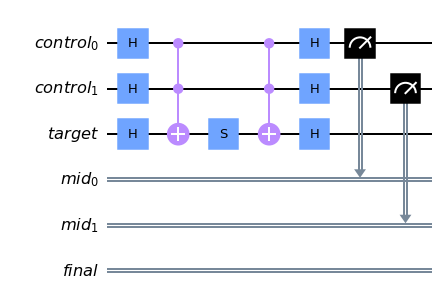

In [23]:
def trial(
    circuit: QuantumCircuit,
    target: QuantumRegister,
    controls: QuantumRegister,
    measures: ClassicalRegister,
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    ########## your code goes here #######

    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
qc.draw("mpl", cregbundle=False)

# Exercise 3

# 1을 측정했으면 0으로 돌리는 reset_controls 함수 만들기

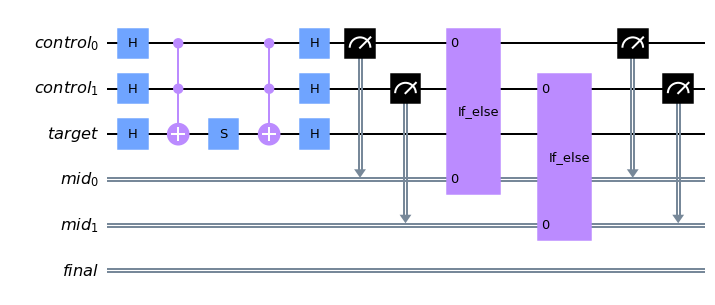

In [26]:
def reset_controls(
    circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    ########## your code goes here #######

    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
reset_controls(qc, controls, mid_measure)
qc.measure(controls, mid_measure)
qc.draw("mpl", cregbundle=False)

# Exercise 4

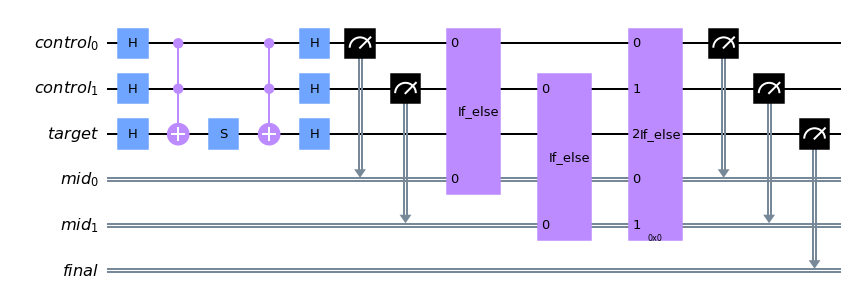

In [25]:
# Set the maximum number of trials
max_trials = 2

# Create a clean circuit with the same structure (bits, registers, etc)
# as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls
# are guaranteed to start in the |0> state.
trial(circuit, target, controls, mid_measure)

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        ########## your code goes here #######

        # First reset the target.
        circuit.x(target)
        # Then repeat the trial.
        trial(circuit, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

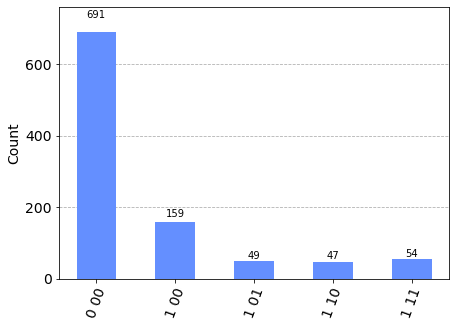

In [13]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)